In [1]:
#install des librairies
#!conda install numpy
#!conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
#!conda instal sklearn

In [2]:
import torch
import networkx as nx
import matplotlib.colors as mcolors

Avec lien : 


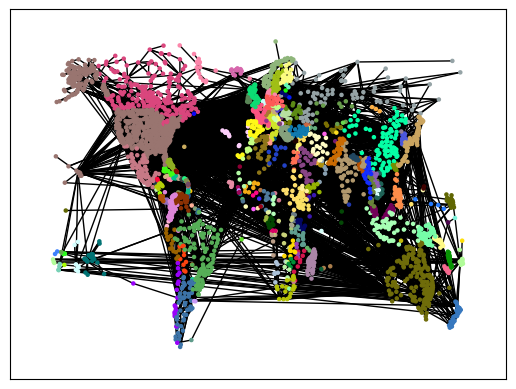

In [3]:
#chargement des données
# Lecture du fichier
G = nx.read_graphml('dataset.graphml')

# Association des couleurs des noeuds en fonction du pays
unique_countries = list(set(G.nodes[node]["country"] for node in G.nodes))
colors_tab = dict(zip(unique_countries,mcolors.get_named_colors_mapping()))
node_colors = [colors_tab[G.nodes[node]["country"]] for node in G.nodes]

# Affichage du graphe avec les noeuds placés à leur position géographique
pos_map = {node: (G.nodes[node]["lon"], G.nodes[node]["lat"]) for node in G.nodes}
print("Avec lien : ")
graphml = nx.draw_networkx(G, pos=pos_map, with_labels=False, node_size=5, node_color=node_colors)

Sans lien : 


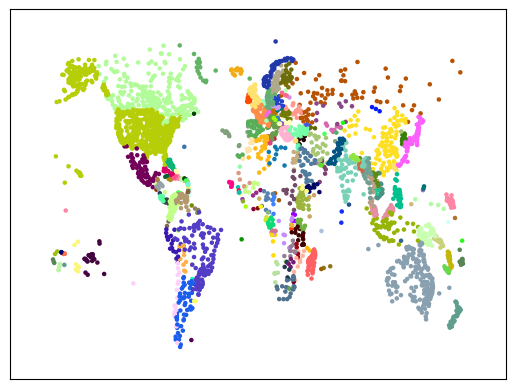

In [4]:
print("Sans lien : ")
graphml = nx.draw_networkx(G, pos=pos_map, with_labels=False, node_size=5, node_color=node_colors, edge_color='none')

 ## Normalization of Data

In [76]:

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
import numpy as np
import torch.nn as nn
import torch.optim as optim


# Extraire les données de population et d'autres attributs pour chaque noeud
data = []
for node, attr in G.nodes(data=True):
    city_name = attr.get('city_name')
    country = attr.get('country')
    population = attr.get('population')
    lat = attr.get('lat')
    lon = attr.get('lon')
    
    # Ajouter les données à une liste ou un DataFrame pour l'analyse
    data.append([city_name, country, population, lat, lon])

# Transformer en DataFrame pour une manipulation plus simple
df = pd.DataFrame(data, columns=['City', 'Country', 'Population', 'Latitude', 'Longitude'])

# Encodage des noms de villes
# Encodage One-Hot des noms de villes et des pays
encoder = OneHotEncoder()
city_country_encoded = encoder.fit_transform(df[['City', 'Country']]).toarray()

# Normalisation des colonnes population, latitude et longitude
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Population', 'Latitude', 'Longitude']])

# Concatenation des données encodées et normalisées
X = np.hstack((city_country_encoded, scaled_data))
processed_data = torch.tensor(X, dtype=torch.float)

# Création d'un mappage des noeuds du graphe
node_map = {node: i for i, node in enumerate(G.nodes)}

# Obtention de l'index des arêtes depuis le graphe G
edges = [(node_map[u], node_map[v]) for u, v in G.edges]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Création d'un objet Data de PyTorch Geometric et division en train/test
data = Data(x=processed_data, edge_index=edge_index)
train_test = train_test_split_edges(data, test_ratio=0.1, val_ratio=0.05)
print(train_test)

c:\Users\runhi\.conda\envs\Apprentissage_TP1\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[3363, 3503], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354])


In [52]:
hyperParam_grid = {
        'eta': 0.00001,
        'batch_size': 64,
        'nb_epochs': 50,
        'Random_Vect_Dim': 50
    }

## Definition du Générateur

In [53]:
# Définition du générateur
class Generator(nn.Module):
    def __init__(self, latent_dim,output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, z):
        return self.model(z)

## Definiton du Discriminateur

In [54]:
# Définition du discriminateur
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.model(x)

## Entraînement du modèle

In [77]:
# 5 dimensions de sortie pour les données de noeuds, nom de la ville, pays, population, lat, lon
generator = Generator(hyperParam_grid.get('Random_Vect_Dim'),5)

# 5 dimensions d'entrée pour les même raisons
discriminator = Discriminator(5)

# Optimiseurs
g_optimizer = optim.Adam(generator.parameters(), lr=hyperParam_grid.get('eta'))
d_optimizer = optim.Adam(discriminator.parameters(), lr=hyperParam_grid.get('eta'))

# Fonction de perte
loss_fn = nn.BCEWithLogitsLoss()

num_epochs = hyperParam_grid.get('nb_epochs')

for epoch in range(1, num_epochs+1):
    # Entraînement du Discriminateur
    d_optimizer.zero_grad()
    
    # Vraies données (train edges)
    node_indices = train_test.train_pos_edge_index[0]  # Récupérer les indices des nœuds
    real_data = train_test.x[node_indices][:, :5]  # Obtenir les caractéristiques des nœuds
    
    real_labels = torch.ones(real_data.size(0), 1)  # Étiquettes pour vraies données
    output_real = discriminator(real_data)  # Passer les vraies données au discriminateur
    loss_real = loss_fn(output_real, real_labels)

    # Fausse données générées par le générateur
    z = torch.randn(real_data.size(0), hyperParam_grid.get('Random_Vect_Dim')) 
    fake_data = generator(z)  # Génération de données fictives
    fake_labels = torch.zeros(fake_data.size(0), 1)
    output_fake = discriminator(fake_data)  # Évaluation des données fictives
    loss_fake = loss_fn(output_fake, fake_labels)
    
    loss_D = loss_real + loss_fake
    loss_D.backward()
    d_optimizer.step()
    
    # Entraînement du Générateur
    g_optimizer.zero_grad()
    
    z = torch.randn(real_data.size(0), hyperParam_grid.get('Random_Vect_Dim'))
    fake_data = generator(z)
    output = discriminator(fake_data)  # Évaluation des données générées
    
    # On veut tromper le discriminateur
    loss_G = loss_fn(output, real_labels)  # Utiliser real_labels pour tromper le discriminateur
    loss_G.backward()
    g_optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

Epoch 10/50, Loss D: 1.3842685222625732, Loss G: 0.6919040083885193
Epoch 20/50, Loss D: 1.3840348720550537, Loss G: 0.6920523047447205
Epoch 30/50, Loss D: 1.3838059902191162, Loss G: 0.6921451687812805
Epoch 40/50, Loss D: 1.383620023727417, Loss G: 0.6922072172164917
Epoch 50/50, Loss D: 1.3834171295166016, Loss G: 0.6922500133514404


In [78]:
# Évaluation sur les arêtes de validation
generator.eval()
discriminator.eval()

with torch.no_grad():
    # Générer des échantillons de bruit pour le générateur
    z = torch.randn(train_test.x.size(0), hyperParam_grid.get('Random_Vect_Dim'))
    generated_data = generator(z)

    # Obtenir les scores du discriminateur pour les données générées et réelles
    output_generated = discriminator(generated_data) 
    node_indices = train_test.train_pos_edge_index[0]
    real_data = train_test.x[node_indices][:, :5]    
    output_real = discriminator(real_data) 
    
    # Appliquer la fonction sigmoid pour obtenir des probabilités
    output_real = torch.sigmoid(output_real)
    output_generated = torch.sigmoid(output_generated)

    # Création des étiquettes
    labels_generated = torch.zeros(output_generated.size(0))
    labels_real = torch.ones(output_real.size(0))

    # Concaténer les sorties et les labels
    outputs = torch.cat((output_real, output_generated), dim=0)
    labels = torch.cat((labels_real, labels_generated), dim=0)


# Calculer l'exactitude
predicted = (outputs > 0.5).float() 
predicted = predicted.squeeze() 
accuracy = (predicted == labels).sum().item() / labels.size(0)
print(f'Accuracy : {accuracy * 100:.2f}%')

# Calculer l'AUC
auc = roc_auc_score(labels.numpy(), outputs.numpy())
print(f'AUC : {auc:.4f}')
ap = average_precision_score(labels.numpy(), outputs.numpy())
print(f'AP : {ap:.4f}')


Accuracy : 91.25%
AUC : 0.9334
AP : 0.9903


In [86]:
# Suppose qu'on crée un décodeur simple pour prédire la population
class PopulationDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(PopulationDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 1)
        self.act = nn.ReLU()

    def forward(self, z):
        return self.act(self.fc(z))

# Instanciation du décodeur
decoder = PopulationDecoder(z.size(1))
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.1)
criterion = nn.MSELoss()

population_normalized = scaler.fit_transform(df[['Population']])
population_real_nor = torch.tensor(population_normalized, dtype=torch.float32).unsqueeze(1)

# Entraînement du décodeur
def train_decoder():
    decoder.train()
    decoder_optimizer.zero_grad()
    predicted_population = decoder(z)
    population_real = torch.tensor(population_real_nor, dtype=torch.float32).unsqueeze(1)
    loss = criterion(predicted_population, population_real)
    loss.backward()
    decoder_optimizer.step()
    return float(loss)
        
# Entraîner le décodeur après avoir obtenu les embeddings latents du modèle VGAE
def test_decoder():
    decoder.eval()
    with torch.no_grad():
        predicted_population = decoder(z)
    return predicted_population

for epoch in range(100):
    loss = train_decoder()
    predicted_population = test_decoder()
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Predicted Population: {predicted_population[:5].squeeze().tolist()}')


C:\Users\runhi\AppData\Local\Temp\ipykernel_16984\2296306112.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  population_real = torch.tensor(population_real_nor, dtype=torch.float32).unsqueeze(1)
c:\Users\runhi\.conda\envs\Apprentissage_TP1\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3363, 1, 1, 1])) that is different to the input size (torch.Size([3363, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 000, Loss: 0.1729, Predicted Population: [0.26153913140296936, 0.0, 0.0, 0.0, 0.0]
Epoch: 010, Loss: 0.0038, Predicted Population: [0.0, 0.0, 0.0, 0.0, 0.0]
Epoch: 020, Loss: 0.0036, Predicted Population: [0.0, 0.0, 0.0, 0.0, 0.0]
Epoch: 030, Loss: 0.0034, Predicted Population: [0.0, 0.0, 0.0, 0.0, 0.0]
Epoch: 040, Loss: 0.0034, Predicted Population: [0.0, 0.0, 0.0, 0.0, 0.0]
Epoch: 050, Loss: 0.0034, Predicted Population: [0.0, 0.0, 0.0, 0.0, 0.0]
Epoch: 060, Loss: 0.0034, Predicted Population: [0.0, 0.0, 0.0, 0.0, 0.0]
Epoch: 070, Loss: 0.0034, Predicted Population: [0.0, 0.0, 0.0, 0.0, 0.0]
Epoch: 080, Loss: 0.0034, Predicted Population: [0.0, 0.0, 0.0, 0.0, 0.0]
Epoch: 090, Loss: 0.0034, Predicted Population: [0.0, 0.0, 0.0, 0.0, 0.0]


In [87]:
# Dénormalisation des populations
predicted_population_denorm = scaler.inverse_transform(predicted_population.cpu().numpy())

# Calcul des écarts entre population réelle et prédite
population_real = df['Population'].values.reshape(-1, 1) 

threshold = 0.1 * np.mean(population_real)  # Seuil pour identifier les anomalies

outliers = np.abs(population_real - predicted_population_denorm) < threshold

# Obtenir les noms des villes suspectes
suspect_cities = df.iloc[outliers]['City'].values

for city in suspect_cities:
    print("Villes avec des anomalies de population: "+ city+ " - " + str(df[df['City'] == city]['Population'].values[0]) )


Villes avec des anomalies de population: Anaa - 10000
Villes avec des anomalies de population: Hao Island - 10000
Villes avec des anomalies de population: Papeete - 26357
Villes avec des anomalies de population: Gambier Island - 10000
Villes avec des anomalies de population: Makemo - 10000
Villes avec des anomalies de population: Atuona - 10000
Villes avec des anomalies de population: Bora Bora - 10000
Villes avec des anomalies de population: Huahine - 10000
Villes avec des anomalies de population: Easter Island - 10000
Villes avec des anomalies de population: Kaukura Atoll - 10000
Villes avec des anomalies de population: Moorea - 10000
Villes avec des anomalies de population: Nuku Hiva - 10000
Villes avec des anomalies de population: Noumea - 10000
Villes avec des anomalies de population: Mataiva - 10000
Villes avec des anomalies de population: Rarotonga - 10000
Villes avec des anomalies de population: Raiatea Island - 10000
Villes avec des anomalies de population: Rangiroa Island - 1

In [88]:
# pourcentage de villes avec des anomalies
print(f'Pourcentage de villes avec des anomalies détectées: {len(suspect_cities) / len(df) * 100:.2f}%')

# pourcentage de villes avec anomalies de population = 10000
cpt = 0
for city in suspect_cities:
    cpt += 1 if df[df['City'] == city]['Population'].values[0] == 10000 else 0
print(f'Pourcentage de villes avec anomalies ayant 10000 de population: {cpt / len(df) * 100:.2f}%')

# pourcentage de ville avec 10000 habitants
print(f'Pourcentage de villes avec 10000 habitants: {len(df[df["Population"] == 10000]) / len(df) * 100:.2f}%')

Pourcentage de villes avec des anomalies détectées: 58.64%
Pourcentage de villes avec anomalies ayant 10000 de population: 49.75%
Pourcentage de villes avec 10000 habitants: 49.75%
